In [1]:
import os
import torch
import albumentations
import albumentations.pytorch
import easydict
import pandas as pd
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
args = easydict.EasyDict({
    "train_data_file_dir": "./data/dirty_mnist_2nd/",
    "train_data_answer_dir": "./data/dirty_mnist_2nd_answer.csv",
})

assert os.path.isdir(args.train_data_file_dir)
assert os.path.isfile(args.train_data_answer_dir)

In [196]:
class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self, image_folder, label_df, transforms):        
        self.image_folder = image_folder   
        self.label_df = label_df
        self.transforms = transforms

    def __len__(self):
        return len(self.label_df)
    
    def __getitem__(self, index):        
        image_fn = self.image_folder +\
            str(self.label_df.iloc[index,0]).zfill(5) + '.png'
                                              
        image = cv2.imread(image_fn, cv2.IMREAD_GRAYSCALE)
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = self.label_df.iloc[index,1:].values.astype('float')

        if self.transforms:            
            image = self.transforms(image=image)['image'] / 255.0

        return image, label

In [339]:
import albumentations.augmentations
import albumentations.augmentations.transforms

In [376]:
transform = albumentations.Compose([
    # albumentations.CLAHE(p=1.0),

    albumentations.RandomBrightnessContrast(),
    albumentations.augmentations.transforms.MotionBlur(),

    albumentations.OneOf([
        albumentations.Cutout(num_holes=16, max_h_size=15, max_w_size=15, fill_value=0, p=1),
        albumentations.Cutout(num_holes=24, max_h_size=13, max_w_size=13, fill_value=0, p=1),
        albumentations.Cutout(num_holes=32, max_h_size=8, max_w_size=8, fill_value=0, p=1),
        ], p=0.5),

    # albumentations.Cutout(num_holes=16, max_h_size=15, max_w_size=15, fill_value=0),

    albumentations.RandomRotate90(),
    albumentations.ShiftScaleRotate(rotate_limit=30, border_mode=cv2.BORDER_CONSTANT),
    albumentations.imgaug.transforms.IAAPerspective(scale=(0.05, 0.1)),
    albumentations.imgaug.transforms.IAAPiecewiseAffine(),

    albumentations.OneOf([
        albumentations.ElasticTransform(alpha=60, sigma=120 * 0.05, alpha_affine=120 * 0.03, border_mode=cv2.BORDER_CONSTANT, p=1),
        albumentations.GridDistortion(distort_limit=(-0.3, 0.3), border_mode=cv2.BORDER_CONSTANT, p=1),
    ], p=0.5),
  
    albumentations.pytorch.ToTensorV2(),
])

data = pd.read_csv(args.train_data_answer_dir)
dataset = DatasetMNIST(
    image_folder=args.train_data_file_dir,
    label_df=data.iloc[:300],
    transforms=transform
)

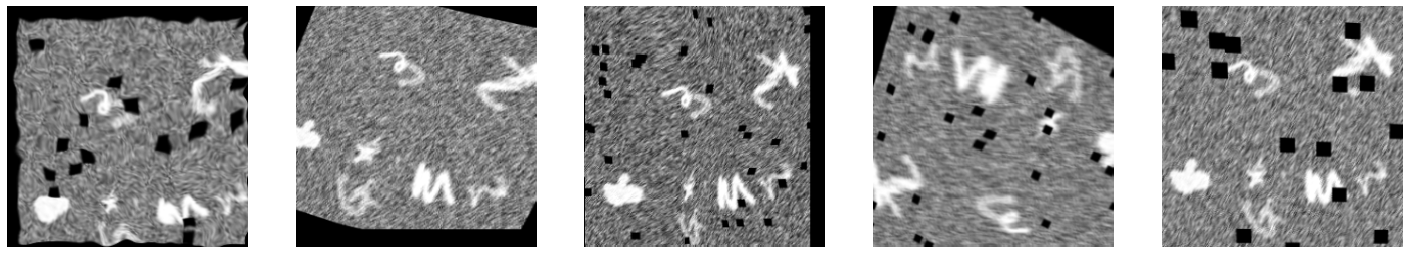

In [389]:
data_idx = np.random.randint(len(dataset))
num_samples = 5

fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))

for i in range(num_samples):
  ax[i].imshow(transforms.ToPILImage()(dataset[data_idx][0]), 'gray')
  ax[i].axis('off')